In [3]:
import pdb;
import scipy.misc as scimisc

from tkinter import *
from PIL import Image
from PIL import ImageTk

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from PIL import Image

import MalmoPython
import os
import sys
import time
import random
import json
import numpy as np
import time
from IPython.display import clear_output,display
import logging
import math


import gym
import gym_minecraft
import itertools
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers

import baselines.common.tf_util as U

from baselines import logger
from baselines import deepq
from baselines.deepq.replay_buffer import ReplayBuffer,PrioritizedReplayBuffer
from baselines.common.schedules import LinearSchedule

In [4]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
from bokeh.driving import linear
from bokeh.layouts import row,gridplot
from IPython.display import clear_output,display
import bokeh
output_notebook()

Loading BokehJS ...

In [5]:
from keras import backend as K
from keras.models import Sequential,model_from_json,Model
from keras.layers import Conv2D,LSTM,GRU,TimeDistributed,Dense,Flatten,Input,Lambda,multiply
from keras.optimizers import RMSprop,Adam
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [6]:
import gym
import gym_minecraft
from MinecraftGym import MinecraftWrapper

## Epsilon Policies

In [7]:
class Policy:
    """Base class representing an MDP policy.

    Policies are used by the agent to choose actions.

    Policies are designed to be stacked to get interesting behaviors
    of choices. For instances in a discrete action space the lowest
    level policy may take in Q-Values and select the action index
    corresponding to the largest value. If this policy is wrapped in
    an epsilon greedy policy then with some probability epsilon, a
    random action will be chosen.
    """

    def select_action(self, **kwargs):
        """Used by agents to select actions.

        Returns
        -------
        Any:
          An object representing the chosen action. Type depends on
          the hierarchy of policy instances.
        """
        raise NotImplementedError('This method should be overriden.')

In [8]:
class LinearDecayGreedyEpsilonPolicy(Policy):
    """Policy with a parameter that decays linearly.

    Like GreedyEpsilonPolicy but the epsilon decays from a start value
    to an end value over k steps.

    Parameters
    ----------
    start_value: int, float
      The initial value of the parameter
    end_value: int, float
      The value of the policy at the end of the decay.
    num_steps: int
      The number of steps over which to decay the value.

    """

    def __init__(self, start_value, end_value, num_steps):  # noqa: D102
        self.start_value = start_value
        self.decay_rate = float(end_value - start_value) / num_steps
        self.end_value = end_value
        self.step = 0
        self.epsilon = start_value

    def update(self,is_training = True):
        """Decay parameter and select action.

        Parameters
        ----------
        q_values: np.array
          The Q-values for each action.
        is_training: bool, optional
          If true then parameter will be decayed. Defaults to true.

        Returns
        -------
        Any:
          Selected action.
        """
        epsilon = self.start_value
        if is_training:
            epsilon += self.decay_rate * self.step
            self.step += 1
        self.epsilon = max(epsilon, self.end_value)

    def reset(self):
        """Start the decay over at the start value."""
        self.step = 0


## Preprocessor

In [9]:
class Preprocessor:
    """Preprocessor base class.

    This is a suggested interface for the preprocessing steps. 

    Preprocessor can be used to perform some fixed operations on the
    raw state from an environment. For example, in ConvNet based
    networks which use image as the raw state, it is often useful to
    convert the image to greyscale or downsample the image.

    Preprocessors are implemented as class so that they can have
    internal state. This can be useful for things like the
    AtariPreproccessor which maxes over k frames.

    If you're using internal states, such as for keeping a sequence of
    inputs like in Atari, you should probably call reset when a new
    episode begins so that state doesn't leak in from episode to
    episode.
    """

    def process_state_for_network(self, state):
        """Preprocess the given state before giving it to the network.

        Should be called just before the action is selected.

        This is a different method from the process_state_for_memory
        because the replay memory may require a different storage
        format to reduce memory usage. For example, storing images as
        uint8 in memory is a lot more efficient thant float32, but the
        networks work better with floating point images.

        Parameters
        ----------
        state: np.ndarray
          Generally a numpy array. A single state from an environment.

        Returns
        -------
        processed_state: np.ndarray
          Generally a numpy array. The state after processing. Can be
          modified in anyway.
        """
        return state

    def process_state_for_memory(self, state):
        """Preprocess the given state before giving it to the replay memory.

        Should be called just before appending this to the replay memory.

        This is a different method from the process_state_for_network
        because the replay memory may require a different storage
        format to reduce memory usage. For example, storing images as
        uint8 in memory and the network expecting images in floating
        point.

        Parameters
        ----------
        state: np.ndarray
          A single state from an environmnet. Generally a numpy array.

        Returns
        -------
        processed_state: np.ndarray
          Generally a numpy array. The state after processing. Can be
          modified in any manner.
        """
        return state

    def process_batch(self, samples):
        """Process batch of samples.

        If your replay memory storage format is different than your
        network input, you may want to apply this function to your
        sampled batch before running it through your update function.

        Parameters
        ----------
        samples: list(tensorflow_rl.core.Sample)
          List of samples to process

        Returns
        -------
        processed_samples: list(tensorflow_rl.core.Sample)
          Samples after processing. Can be modified in anyways, but
          the list length will generally stay the same.
        """
        return samples

    def process_reward(self, reward):
        """Process the reward.

        Useful for things like reward clipping. The Atari environments
        from DQN paper do this. Instead of taking real score, they
        take the sign of the delta of the score.

        Parameters
        ----------
        reward: float
          Reward to process

        Returns
        -------
        processed_reward: float
          The processed reward
        """
        return reward

    def reset(self):
        """Reset any internal state.

        Will be called at the start of every new episode. Makes it
        possible to do history snapshots.
        """
        pass

In [10]:
class AtariPreprocessor(Preprocessor):
    """Converts images to greyscale and downscales.

    Based on the preprocessing step described in:

    @article{mnih15_human_level_contr_throug_deep_reinf_learn,
    author =	 {Volodymyr Mnih and Koray Kavukcuoglu and David
                  Silver and Andrei A. Rusu and Joel Veness and Marc
                  G. Bellemare and Alex Graves and Martin Riedmiller
                  and Andreas K. Fidjeland and Georg Ostrovski and
                  Stig Petersen and Charles Beattie and Amir Sadik and
                  Ioannis Antonoglou and Helen King and Dharshan
                  Kumaran and Daan Wierstra and Shane Legg and Demis
                  Hassabis},
    title =	 {Human-Level Control Through Deep Reinforcement
                  Learning},
    journal =	 {Nature},
    volume =	 518,
    number =	 7540,
    pages =	 {529-533},
    year =	 2015,
    doi =        {10.1038/nature14236},
    url =	 {http://dx.doi.org/10.1038/nature14236},
    }

    You may also want to max over frames to remove flickering. Some
    games require this (based on animations and the limited sprite
    drawing capabilities of the original Atari).

    Parameters
    ----------
    new_size: 2 element tuple
      The size that each image in the state should be scaled to. e.g
      (84, 84) will make each image in the output have shape (84, 84).
    """
    
    def __init__(self,new_state_shape):
        self.new_shape = new_state_shape
    def process_state_for_memory(self, state):
        """Scale, convert to greyscale and store as uint8.

        We don't want to save floating point numbers in the replay
        memory. We get the same resolution as uint8, but use a quarter
        to an eigth of the bytes (depending on float32 or float64)

        We recommend using the Python Image Library (PIL) to do the
        image conversions.
        """
        img = Image.fromarray(state).convert('L').resize(self.new_shape[:2], Image.BILINEAR)
        state = np.array(img)
        return np.expand_dims(state,-1)
    def process_for_network(self, state):
        """Scale, convert to greyscale and store as float32.

        Basically same as process state for memory, but this time
        outputs float32 images.
        """
        state = np.float32(state / 255.0)
        return state

    def process_batch(self, samples):
        """The batches from replay memory will be uint8, convert to float32.

        Same as process_state_for_network but works on a batch of
        samples from the replay memory. Meaning you need to convert
        both state and next state values.
        """
        return np.float32(samples / 255.0)
            

    def process_reward(self, reward):
        """Clip reward between -1 and 1."""
        return np.clip(reward, -1, 1) 
    
    def reset(self):
        self.last_state = None

## Loss

In [11]:
def huber_loss(y_true, y_pred, max_grad=1.):
    """Calculate the huber loss.

    See https://en.wikipedia.org/wiki/Huber_loss

    Parameters
    ----------
    y_true: np.array, tf.Tensor
      Target value.
    y_pred: np.array, tf.Tensor
      Predicted value.
    max_grad: float, optional
      Positive floating point value. Represents the maximum possible
      gradient magnitude.

    Returns
    -------
    tf.Tensor
      The huber loss.
    """
    with tf.variable_scope("HuberLoss"):
        delta = max_grad 
        diff = tf.abs(y_true - y_pred, name = "diff")
        mask = diff < delta
        return tf.where(mask, 0.5 * tf.square(diff), delta * (diff - 0.5 * delta))

def mean_huber_loss(y_true, y_pred, max_grad=1.):
    """Return mean huber loss.

    Same as huber_loss, but takes the mean over all values in the
    output tensor.

    Parameters
    ----------
    y_true: np.array, tf.Tensor
      Target value.
    y_pred: np.array, tf.Tensor
      Predicted value.
    max_grad: float, optional
      Positive floating point value. Represents the maximum possible
      gradient magnitude.

    Returns
    -------
    tf.Tensor
      The mean huber loss.
    """
    return tf.reduce_mean(huber_loss(y_true, y_pred, max_grad))

## Brain

In [12]:
class Network:
    def __init__(self,stateCnt,actionCnt,recurrent,mode,learning_rate):
        self.stateCnt = stateCnt
        self.actionCnt = actionCnt
        self.learning_rate = learning_rate
        #self.batch_size = batch_size
        
        self.recurrent = recurrent
        self.mode = mode
        
    def build(self):
        model = Sequential()
        model.add(TimeDistributed(Conv2D(64, (3, 3)),
                          input_shape=self.stateCnt,batch_size=self.batch_size))
        
        #model.add(layers.TimeDistributed(layers.Conv2D(32,(8,8),input_shape=self.stateCnt,activation='relu')))
        conv2 = layers.Conv2D(64,(4,4),activation='relu')
        conv3 = layers.Conv2D(64,(3,3),activation='relu')
        model.add(layers.TimeDistributed(conv2))
        model.add(layers.TimeDistributed(conv3))
        model.add(layers.TimeDistributed(layers.Flatten()))
        #model.add(layers.Flatten())
        #model.add(layers.Permute((0,2,1)))
        #self.add(Reshape(input_width, num_filters))
        model.add(layers.GRU(units=70,stateful=True))
        #model.add(layers.Dense(256,activation='relu')
        model.add(layers.Dense(output_dim=self.actionCnt))
        
        model.compile(loss=self._huber_loss,optimizer=Adam(lr=self.learning_rate))
        return model
    def build2(self):
        inpt = Input(shape = self.stateCnt, name = "input")
        
        if self.mode == "linear":
            
            flatten_hidden = Flatten(name = "flatten")(input_data)
            output = Dense(num_actions, name = "output")(flatten_hidden)
        else:
            if self.recurrent:
                # shape should be (timesteps,height,width,color)
                conv1 = TimeDistributed(Conv2D(32, (8, 8), strides = 4, activation = "relu", name = "conv1"))(inpt)
                conv2 = TimeDistributed(Conv2D(64, (4, 4), strides = 2, activation = "relu", name = "conv2"))(conv1)
                conv3 = TimeDistributed(Conv2D(64, (3, 3), strides = 1, activation = "relu", name = "conv3"))(conv2)
                flatten_hidden = TimeDistributed(Flatten())(conv3)
                hidden_input = TimeDistributed(Dense(512, activation = 'relu', name = 'flat_to_512')) (flatten_hidden)
                context = LSTM(512, return_sequences=False, stateful=False) (hidden_input)
                
            if self.mode == "dqn":
                h4 = Dense(512, activation='relu', name = "fc")(context)
                output = Dense(num_actions, name = "output")(h4)
            elif self.mode == "duel":
                value_hidden = Dense(512, activation = 'relu', name = 'value_fc')(context)
                value = Dense(1, name = "value")(value_hidden)
                
                action_hidden = Dense(512, activation = 'relu', name = 'action_fc')(context)
                action = Dense(self.actionCnt, name = "action")(action_hidden)
                
                action_mean = Lambda(lambda x: K.mean(x, axis = 1, keepdims = True), name = 'action_mean')(action) 
                output = Lambda(lambda x: x[0] + x[1] - x[2], name = 'output')([action, value, action_mean])
        model = Model(inputs = inpt, outputs = output)
        model.compile(loss=self.mean_huber_loss,optimizer=Adam(lr=self.learning_rate))
        return model
            
        
    def pseudo_huber_loss(self, target, prediction):
        # don't use this as a loss function, keeping this as an example of what not to do
        error = prediction - target
        return K.mean(K.sqrt(1+K.square(error))-1, axis=-1)
    def huber_loss(self,y_true, y_pred, max_grad=1.):
        """Calculate the huber loss.

        See https://en.wikipedia.org/wiki/Huber_loss

        Parameters
        ----------
        y_true: np.array, tf.Tensor
          Target value.
        y_pred: np.array, tf.Tensor
          Predicted value.
        max_grad: float, optional
          Positive floating point value. Represents the maximum possible
          gradient magnitude.

        Returns
        -------
        tf.Tensor
          The huber loss.
        """
        with K.name_scope("HuberLoss"):
            delta = max_grad 
            diff = tf.abs(y_true - y_pred, name = "diff")
            mask = diff < delta
            return tf.where(mask, 0.5 * tf.square(diff), delta * (diff - 0.5 * delta))

    def mean_huber_loss(self,y_true, y_pred, max_grad=1.):
        """Return mean huber loss.

        Same as huber_loss, but takes the mean over all values in the
        output tensor.

        Parameters
        ----------
        y_true: np.array, tf.Tensor
          Target value.
        y_pred: np.array, tf.Tensor
          Predicted value.
        max_grad: float, optional
          Positive floating point value. Represents the maximum possible
          gradient magnitude.

        Returns
        -------
        tf.Tensor
          The mean huber loss.
        """
        return tf.reduce_mean(self.huber_loss(y_true, y_pred, max_grad))
    

## Memory

In [13]:
class ShortMemory():
    def __init__(self,hist_len,state_dim):
        self.history_length = hist_len
        self.state_dim = state_dim
        self.mem_hist = np.zeros((hist_len,) + state_dim , dtype = np.float32)
        self.current = 0
    def add(self,state):
        self.mem_hist[self.current % self.history_length] = state
        self.current += 1
    def get(self):
        '''
        This function provides the recent history of length history_length.
        The sample in the beginning will be padded at the beginning. (0,0,0..data)
        '''
        return self.mem_hist
    
    def forget(self):
        self.mem_hist = np.zeros((self.history_length,) + self.state_dim, dtype = np.float32)
        self.current = 0
    

In [14]:
class Memory():
    def __init__(self,capacity,hist_len,s_dim):
        '''
        capacity: how many episodes to store?
        hist_len: what is the history length of each episode?
        s_dim: the size of your state in a tuple ex. (80,80,1) 
        '''
        self.memory_size = capacity
        self.history_length = hist_len
        self.state_dim = s_dim
        self.mem_a = np.zeros(self.memory_size, dtype = np.int8)
        self.mem_r = np.zeros(self.memory_size, dtype = np.int8)
        self.mem_s = np.zeros((self.memory_size,) + s_dim , dtype = np.uint8)
        self.dones = np.zeros(self.memory_size, dtype = np.bool)
        self.current = 0
    def get_state(self,idx):
        state = self.mem_s[idx - self.history_length + 1:idx + 1, :, :]
        assert len(state) <= self.history_length
        #print(len(state))
        if len(state) < self.history_length:
            pad = self.history_length - len(state)
            pad_shape = (pad,) + self.state_dim
            #print("pad {}".format(pad_shape))
            pad_arr = np.zeros((pad,) + self.state_dim)

            state = np.concatenate((pad_arr,state),axis=0)
            #print(state.shape)

        return state
    def add(self,s,a,r,done):
        self.mem_a[self.current % self.memory_size] = a
        self.mem_r[self.current % self.memory_size] = r
        self.mem_s[self.current % self.memory_size] = s
        self.dones[self.current % self.memory_size] = done
        self.current += 1 
    def sample(self, batch_size):
        indexes = []
        # ensure enough frames to sample
        assert self.current > self.history_length
        # -1 because still need next frame
        end = min(self.current, self.memory_size) - 1

        while len(indexes) < batch_size: 
            index = np.random.randint(self.history_length - 1, end)
            # sampled state shouldn't contain episode end
            if self.dones[index - self.history_length + 1: index + 1].any():
                continue
            indexes.append(index)

        smp_s = []
        smp_a = [] 
        smp_r = []
        smp_s_ = []
        smp_done = []
        for idx in indexes:
            smp_s.append(self.get_state(idx))
            smp_a.append(self.mem_a[idx])
            smp_r.append(self.mem_r[idx])
            smp_s_.append(self.get_state(idx + 1))
            smp_done.append(self.dones[idx])
        return np.array(smp_s),np.array(smp_a),np.array(smp_r),np.array(smp_s_),np.array(smp_done)

## Agent

In [15]:
# There are way too many parameters for the agent to be within the init arguments
class AgentConfig():
    def __init__(self):
        '''
        stateCnt 
        actionCnt 
        mem_size
        epsilon_policy 
        gamma 
        num_frames
        learning_rate 
        train_start 
        train_freq 
        target_update_freq  
        batch_size 
        preprocessor 
        log_path 
        name      
        '''
        self.stateCnt = None
        self.actionCnt = None
        self.mem_size = None
        self.epsilon_policy = None
        self.gamma = None
        self.num_frames = None
        self.learning_rate = None
        self.train_start = None
        self.train_freq = None
        self.target_update_freq = None 
        self.batch_size = None
        self.preprocessor = None
        self.log_path = None
        self.name = None
    def validate(self):
        # validate parameters
        pass

In [ ]:
cfg = AgentConfig()
cfg.stateCnt = 
cfg.actionCnt = None
cfg.mem_size = None
cfg.epsilon_policy = None
cfg.gamma = None
cfg.num_frames = None
cfg.learning_rate = None
cfg.train_start = None
cfg.train_freq = None
cfg.target_update_freq = None 
cfg.batch_size = None
cfg.preprocessor = None
cfg.log_path = None
cfg.name = None

In [24]:
class Agent:
    
    def __init__(self,cfg):
        self.stateCnt = cfg.stateCnt
        if cfg.preprocessor:
            self.preprocessor = cfg.preprocessor
            self.stateCnt = cfg.preprocessor.new_shape
        
        self.actionCnt = cfg.actionCnt
        


        # initialize memory
        self.longmem = Memory(cfg.mem_size,cfg.num_frames,self.stateCnt)
        self.shortmem = ShortMemory(cfg.num_frames,self.stateCnt)
        
        
        self.epsilon_policy = cfg.epsilon_policy
        self.gamma = cfg.gamma
        self.target_update_freq = cfg.target_update_freq
        
        self.name = cfg.name
        self.learning_rate = cfg.learning_rate 
        self.train_start = cfg.train_start
        self.train_freq = cfg.train_freq
        self.batch_size = cfg.batch_size
        
        # build network
        inpt = (cfg.num_frames,) + self.stateCnt
        self.net_inpt = inpt
        self.model = Network(inpt,self.actionCnt,True,'duel',cfg.learning_rate).build2() # model
        self.target_model = Network(inpt,self.actionCnt,True,'duel',cfg.learning_rate).build2() # target model
        self.final_model = None
        self.compile()
        #logging
        if cfg.log_path:
            self.writer = tf.summary.FileWriter(cfg.log_path)
            self.log_path = cfg.log_path
        # init counters for logging purpose
        self.loss_count = 0
        self.counter = 0
    def save_model(self):
        self.model.save_weights(self.log_path + "/" + self.name)
    def remember(self,s,a,r,done):
        self.longmem.add(s,a,r,done)
    def save_scalar(self,step, name, value):
        """Save a scalar value to tensorboard.
          Parameters
          ----------
          step: int
            Training step (sets the position on x-axis of tensorboard graph.
          name: str
            Name of variable. Will be the name of the graph in tensorboard.
          value: float
            The value of the variable at this step.
          writer: tf.FileWriter
            The tensorboard FileWriter instance.
          """
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = float(value)
        summary_value.tag = name
        self.writer.add_summary(summary, step)
    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())
        
    def compile(self, optimizer = None, loss_func = None):
        """Setup all of the TF graph variables/ops.

        This is inspired by the compile method on the
        keras.models.Model class.

        This is the place to create the target network, setup 
        loss function and any placeholders.
        """
        if loss_func is None:
            loss_func = mean_huber_loss
            # loss_func = 'mse'
        if optimizer is None:
            optimizer = Adam(lr = self.learning_rate)
            # optimizer = RMSprop(lr=0.00025)
        with tf.variable_scope("Loss"):
            state = Input(shape = (*self.net_inpt, ) , name = "states")
            action_mask = Input(shape = (self.actionCnt,), name = "actions")
            qa_value = self.model(state)
            qa_value = multiply([qa_value, action_mask], name = "multiply")
            qa_value = Lambda(lambda x: tf.reduce_sum(x, axis=1, keep_dims = True), name = "sum")(qa_value)

        self.final_model = Model(inputs = [state, action_mask], outputs = qa_value)
        self.final_model.compile(loss=loss_func, optimizer=optimizer)

    def act(self, s, episode=0):
        # Epsilon greedy action selection
        s = s[None] # increase the rank of tensor to have a batch_size of 1 and length 1
        if episode >= self.train_start:
            self.epsilon_policy.update()
        if np.random.rand() <= self.epsilon_policy.epsilon:
            return random.randrange(self.actionCnt)
        act_values = self.model.predict_on_batch(s)
        return np.argmax(act_values[0]) # returns action
    def replay(self,batch_size):
        prebatch_s,batch_a,batch_r,prebatch_s_,batch_done = self.longmem.sample(batch_size)# a batch of episode of parameter length
        
        batch_s = self.preprocessor.process_batch(prebatch_s)
        batch_s_ = self.preprocessor.process_batch(prebatch_s_)
        
        a_ = self.model.predict(batch_s_)
        a_idx = np.argmax(a_,axis=1)
        behaviour_q = self.target_model.predict(batch_s_)
        action_mask = np.zeros((batch_size, self.actionCnt))
        action_mask[range(batch_size), batch_a] = 1.0
        #target = self.model.predict(batch_s) [range(batch_size),batch_a.astype('int')] # smaller update for other residuals? research if this actually makes in impact?
        
        target = batch_r + self.gamma * (behaviour_q[range(batch_size),a_idx]) 
        loss = self.final_model.train_on_batch([batch_s,action_mask],target)
        
        return loss, np.mean(target)

    def train2(self, env, num_iterations, max_episode_length=None):
        """Fit your model to the provided environment.

        This is where you sample actions from your network,
        collect experience samples and add them to your replay memory,
        and update your network parameters.

        Parameters
        ----------
        env: gym.Env
          This is the Atari environment. 
        num_iterations: int
          How many samples/updates to perform.
        max_episode_length: int
          How long a single episode should last before the agent
          resets. Can help exploration.
        """
        is_training = True
        print("Training starts.")
        #self.save_model(0)
        eval_count = 0

        pre_s = env.reset()
        mem_s = self.preprocessor.process_state_for_memory(pre_s) #scaled and grayscaled
        net_s = self.preprocessor.process_for_network(mem_s) # normalized
        burn_in = True
        idx_episode = 1
        episode_loss = .0
        episode_frames = 0
        episode_reward = .0
        episode_raw_reward = .0
        episode_target_value = .0
        for t in range(self.num_burn_in + num_iterations):
            self.shortmem.add(net_s)
            hist_
            action_state = self.history_processor.process_state_for_network(
                self.atari_processor.process_state_for_network(state))
            policy_type = "UniformRandomPolicy" if burn_in else "LinearDecayGreedyEpsilonPolicy"
            action = self.select_action(action_state, is_training, policy_type = policy_type)
            processed_state = self.atari_processor.process_state_for_memory(state)

            state, reward, done, info = env.step(action)

            processed_next_state = self.atari_processor.process_state_for_network(state)
            action_next_state = np.dstack((action_state, processed_next_state))
            action_next_state = action_next_state[:, :, 1:]

            processed_reward = self.atari_processor.process_reward(reward)

            self.memory.append(processed_state, action, processed_reward, done)
            current_sample = Sample(action_state, action, processed_reward, action_next_state, done)
            
            if not burn_in: 
                episode_frames += 1
                episode_reward += processed_reward
                episode_raw_reward += reward
                if episode_frames > max_episode_length:
                    done = True

            if done:
                # adding last frame only to save last state
                last_frame = self.atari_processor.process_state_for_memory(state)
                # action, reward, done doesn't matter here
                self.memory.append(last_frame, action, 0, done)
                if not burn_in:
                    avg_target_value = episode_target_value / episode_frames
                    print(">>> Training: time %d, episode %d, length %d, reward %.0f, raw_reward %.0f, loss %.4f, target value %.4f, policy step %d, memory cap %d" % 
                        (t, idx_episode, episode_frames, episode_reward, episode_raw_reward, episode_loss, 
                        avg_target_value, self.policy.step, self.memory.current))
                    sys.stdout.flush()
                    save_scalar(idx_episode, 'train/episode_frames', episode_frames, self.writer)
                    save_scalar(idx_episode, 'train/episode_reward', episode_reward, self.writer)
                    save_scalar(idx_episode, 'train/episode_raw_reward', episode_raw_reward, self.writer)
                    save_scalar(idx_episode, 'train/episode_loss', episode_loss, self.writer)
                    save_scalar(idx_episode, 'train_avg/avg_reward', episode_reward / episode_frames, self.writer)
                    save_scalar(idx_episode, 'train_avg/avg_target_value', avg_target_value, self.writer)
                    save_scalar(idx_episode, 'train_avg/avg_loss', episode_loss / episode_frames, self.writer)
                    episode_frames = 0
                    episode_reward = .0
                    episode_raw_reward = .0
                    episode_loss = .0
                    episode_target_value = .0
                    idx_episode += 1
                burn_in = (t < self.num_burn_in)
                state = env.reset()
                self.atari_processor.reset()
                self.history_processor.reset()

            if not burn_in:
                if t % self.train_freq == 0:
                    loss, target_value = self.update_policy(current_sample)
                    episode_loss += loss
                    episode_target_value += target_value
                # update freq is based on train_freq
                if t % (self.train_freq * self.target_update_freq) == 0:
                    # target updates can have the option to be hard or soft
                    # related functions are defined in deeprl_prj.utils
                    # here we use hard target update as default
                    self.target_network.set_weights(self.q_network.get_weights())
                if t % self.save_freq == 0:
                    self.save_model(idx_episode)
                if t % (self.eval_freq * self.train_freq) == 0:
                    episode_reward_mean, episode_reward_std, eval_count = self.evaluate(env, 20, eval_count, max_episode_length, True)
                    save_scalar(t, 'eval/eval_episode_reward_mean', episode_reward_mean, self.writer)
                    save_scalar(t, 'eval/eval_episode_reward_std', episode_reward_std, self.writer)

    def train(self,env,episodes,render = False):
        e_idx = 0
        # play loop
        print("Training")
        for e in range(episodes):
            # stats
            e_loss = .0
            e_length = .0
            e_r = .0
            e_raw_r = .0
            e_target_val = .0
            
            
            #agent.model.reset_states()
            pre_s = env.reset()
            mem_s = self.preprocessor.process_state_for_memory(pre_s) #scaled and grayscaled
            net_s = self.preprocessor.process_for_network(mem_s) # normalized
            done = False
            self.shortmem.forget # forget short term memory for recurrent network 
            self.shortmem.add(net_s)
            if e % 40 == 0:
                self.save_model()
            for t in itertools.count():
                hist_s = self.shortmem.get() # receive the last frames including the most recent frame to make a tensor shape (num_frames,frame_dim)
                # take action using net_s and receive a
                a = self.act(hist_s,e)
                if render:
                    env.render()

                pre_s_, raw_r, done, info = env.step(a)
                
                r = self.preprocessor.process_reward(raw_r) # reward clipping
                mem_s_ = self.preprocessor.process_state_for_memory(pre_s) #scaled and grayscaled
                net_s_ = self.preprocessor.process_for_network(mem_s) # normalized
        
                agent.shortmem.add(net_s_)
                agent.remember(mem_s,a,r,done)
                
                # collect stats
                e_raw_r += raw_r
                e_r += r
                

                if e > self.train_start:
                    
                    if t % (self.train_freq *self.target_update_freq) == 0:
                        self.update_target_model()
                    
                    if t % self.train_freq == 0  :
                        loss, avg_target = self.replay(self.batch_size)
                        e_loss += loss
                        e_target_val += avg_target
            
                if done:
                    print("Training: episode %d, length %d, reward %.0f, raw_reward %.0f, loss %.4f, target value %.4f,, memory cap %d" % 
                        (e, t, e_r, e_raw_r, e_loss, e_target_val/t, self.longmem.current))
                    if e > self.train_start:
                        e_idx += 1
                        self.save_scalar(e_idx,"train/episode_reward",e_r)
                        self.save_scalar(e_idx,"train/episode_raw_reward",e_raw_r)
                        self.save_scalar(e_idx,"train/episode_frames",t)
                        self.save_scalar(e_idx,"train/episode_loss",e_loss)
                        self.save_scalar(e_idx,"train_avg/avg_target_value",e_target_val/t)
                    break

# Environment

In [ ]:
def preprocess(rgb_array,scale = 1/12):
    frame_shape = rgb_array.shape
    
    frame = np.array(rgb_array)
    gray_frame = np.dot(frame[...,:3],[0.299,0.587,0.114]).reshape((frame_shape[0],frame_shape[1]))
    smaller = scimisc.imresize(gray_frame,scale,mode='L').astype('float64')
    smaller /= 255.0
    smaller = np.expand_dims(smaller,2) # convert to a 3D array of shape (height,width,grayscale)
    smaller = np.reshape(smaller, [1, *(smaller.shape)])
    return smaller.astype("uint8")

In [ ]:
def render(obs,root,canvas):
    obs = np.squeeze(obs,2)
    image = Image.fromarray(obs.astype('int8'),mode='L')
    photo = ImageTk.PhotoImage(image)
    root.one = photo
    canvas.delete("all")
    canvas.create_image(frame_height,frame_width, image=photo)
    root.update()

In [ ]:

def get_output_folder(args, parent_dir, env_name, task_name):
    """Return save folder.
    Assumes folders in the parent_dir have suffix -run{run
    number}. Finds the highest run number and sets the output folder
    to that number + 1. This is just convenient so that if you run the
    same script multiple times tensorboard can plot all of the results
    on the same plots with different names.
    Parameters
    ----------
    parent_dir: str
      Path of the directory containing all experiment runs.
    Returns
    -------
    parent_dir/run_dir
      Path to this run's save directory.
    """
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
        print('===== Folder did not exist; creating... %s'%parent_dir)
    experiment_id = 0
    for folder_name in os.listdir(parent_dir):
        if not os.path.isdir(os.path.join(parent_dir, folder_name)):
            continue
        try:
            folder_name = int(folder_name.split('-run')[-1])
            if folder_name > experiment_id:
                experiment_id = folder_name
        except:
            pass
    experiment_id += 1

    parent_dir = os.path.join(parent_dir, env_name)
    parent_dir = parent_dir + '-run{}'.format(experiment_id) + '-' + task_name
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
        print('===== Folder did not exist; creating... %s'%parent_dir)
    else:
        print('===== Folder exists; delete? %s'%parent_dir)
        input("Press Enter to continue...")
        os.system('rm -rf %s/' % (parent_dir))
    os.makedirs(parent_dir+'/videos/')
    os.makedirs(parent_dir+'/images/')
    return parent_dir

## Test

In [ ]:
# Test

root = Tk()
root_frame = Frame(root)
canvas = Canvas(root_frame, borderwidth=0, highlightthickness=0, width=200, height=130, bg="black" )
root_frame.pack()
canvas.pack()

frame_height = 25
frame_width = 35


env = gym.make("MinecraftBasic-v0")
env.load_mission_file("./CliffWalking.xml")
env.init(videoResolution=[420,300],allowContinuousMovement=["move", "turn", "strafe"])


scale = 1/12 # scale image down by 1/12
newshape = (env.video_height*scale,env.video_width*scale,1) # dimension of 1 for grayscale
newshape = tuple(map(int,newshape))

# the pre processor will adjust the observation space therefore we will edit the property of the environment to take the pre processor into accoutn
env.observation_space = gym.spaces.Box(low=0, high=255,
shape=newshape)

done = False

for i in range(1000):
    try:
        env.reset()
        while True:
            action = env.action_space.sample()
            obs, reward, done, info = env.step(action)
            proc_obs = preprocess(obs)
            
            render(proc_obs,root_frame,canvas)

            if done:
                break
    except:
        root.destroy()
        env.close()
        raise
env.close()
root.destroy()


# Plots

In [ ]:
def update(x,y,handle,plot):
    plot.data_source.data['x'] += [x]
    plot.data_source.data['y'] += [y]
    push_notebook(handle=handle)

In [ ]:
inferno = bokeh.palettes.Inferno9
fig1 = figure(plot_width=400, plot_height=400,title="rewards",
                      x_axis_label="x",
                      y_axis_label="y")
rplot = fig1.line([],[],line_width=2)
# make a grid
handle1 = show(fig1, notebook_handle=True)

reward_plot = {"handle":handle1,"plot":rplot}

# Execute

In [17]:
pre_env = gym.make("MinecraftCliffWalking1-v0")
pre_env.init(videoResolution=[400,400],allowContinuousMovement=["move", "turn", "strafe"],observeGrid=[20,-1,20,20,-1,20],observeDistance=[4,45,12])
env = MinecraftWrapper(pre_env,1/5,(41,41))

In [18]:
atari_env = gym.make('Seaquest-v0')

In [19]:
def get_output_folder(args, parent_dir, env_name, task_name):
    """Return save folder.
    Assumes folders in the parent_dir have suffix -run{run
    number}. Finds the highest run number and sets the output folder
    to that number + 1. This is just convenient so that if you run the
    same script multiple times tensorboard can plot all of the results
    on the same plots with different names.
    Parameters
    ----------
    parent_dir: str
      Path of the directory containing all experiment runs.
    Returns
    -------
    parent_dir/run_dir
      Path to this run's save directory.
    """
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
        print('===== Folder did not exist; creating... %s'%parent_dir)
    experiment_id = 0
    for folder_name in os.listdir(parent_dir):
        if not os.path.isdir(os.path.join(parent_dir, folder_name)):
            continue
        try:
            folder_name = int(folder_name.split('-run')[-1])
            if folder_name > experiment_id:
                experiment_id = folder_name
        except:
            pass
    experiment_id += 1

    parent_dir = os.path.join(parent_dir, env_name)
    parent_dir = parent_dir + '-run{}'.format(experiment_id) + '-' + task_name
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
        print('===== Folder did not exist; creating... %s'%parent_dir)
    else:
        print('===== Folder exists; delete? %s'%parent_dir)
        input("Press Enter to continue...")
        os.system('rm -rf %s/' % (parent_dir))
    #s.makedirs(parent_dir+'/videos/')
    #os.makedirs(parent_dir+'/images/')
    return parent_dir

In [25]:
doc = get_output_folder(None,"./logs","Seaquest-v8","DQRN-Batch")

===== Folder exists; delete? ./logs/Seaquest-v8-run1-DQRN-Batch
Press Enter to continue...


In [26]:
doc


'./logs/Seaquest-v8-run1-DQRN-Batch'

In [27]:
episodes = 100000
cfg = AgentConfig()
cfg.stateCnt = atari_env.observation_space.shape
cfg.actionCnt = atari_env.action_space.n
cfg.mem_size = 1000000
cfg.epsilon_policy = LinearDecayGreedyEpsilonPolicy(1.0,0.05,episodes)
cfg.gamma = 0.99
cfg.num_frames = 10
cfg.learning_rate = 0.001
cfg.train_start = 200
cfg.train_freq = 3
cfg.target_update_freq = 70
cfg.batch_size = 32
cfg.preprocessor = AtariPreprocessor((84,84,1))
cfg.log_path = doc
cfg.name = "A3"
agent = Agent(cfg)

In [ ]:
agent.train(atari_env,episodes,render=True)

Training
Training: episode 0, length 775, reward 3, raw_reward 60, loss 0.0000, target value 0.0000,, memory cap 776
Training: episode 1, length 583, reward 2, raw_reward 40, loss 0.0000, target value 0.0000,, memory cap 1360
Training: episode 2, length 662, reward 2, raw_reward 40, loss 0.0000, target value 0.0000,, memory cap 2023
Training: episode 3, length 870, reward 7, raw_reward 140, loss 0.0000, target value 0.0000,, memory cap 2894
Training: episode 4, length 585, reward 2, raw_reward 40, loss 0.0000, target value 0.0000,, memory cap 3480
Training: episode 5, length 1016, reward 5, raw_reward 100, loss 0.0000, target value 0.0000,, memory cap 4497
Training: episode 6, length 640, reward 1, raw_reward 20, loss 0.0000, target value 0.0000,, memory cap 5138
Training: episode 7, length 498, reward 0, raw_reward 0, loss 0.0000, target value 0.0000,, memory cap 5637
Training: episode 8, length 733, reward 3, raw_reward 60, loss 0.0000, target value 0.0000,, memory cap 6371
Training:

Training: episode 74, length 649, reward 3, raw_reward 60, loss 0.0000, target value 0.0000,, memory cap 50811
Training: episode 75, length 423, reward 0, raw_reward 0, loss 0.0000, target value 0.0000,, memory cap 51235
Training: episode 76, length 592, reward 3, raw_reward 60, loss 0.0000, target value 0.0000,, memory cap 51828
Training: episode 77, length 684, reward 4, raw_reward 80, loss 0.0000, target value 0.0000,, memory cap 52513
Training: episode 78, length 460, reward 0, raw_reward 0, loss 0.0000, target value 0.0000,, memory cap 52974
Training: episode 79, length 713, reward 4, raw_reward 80, loss 0.0000, target value 0.0000,, memory cap 53688
Training: episode 80, length 916, reward 5, raw_reward 100, loss 0.0000, target value 0.0000,, memory cap 54605
Training: episode 81, length 609, reward 3, raw_reward 60, loss 0.0000, target value 0.0000,, memory cap 55215
Training: episode 82, length 498, reward 3, raw_reward 60, loss 0.0000, target value 0.0000,, memory cap 55714
Tr

Training: episode 148, length 733, reward 4, raw_reward 80, loss 0.0000, target value 0.0000,, memory cap 104947
Training: episode 149, length 562, reward 1, raw_reward 20, loss 0.0000, target value 0.0000,, memory cap 105510
Training: episode 150, length 911, reward 5, raw_reward 100, loss 0.0000, target value 0.0000,, memory cap 106422
Training: episode 151, length 555, reward 2, raw_reward 40, loss 0.0000, target value 0.0000,, memory cap 106978
Training: episode 152, length 597, reward 2, raw_reward 40, loss 0.0000, target value 0.0000,, memory cap 107576
Training: episode 153, length 494, reward 2, raw_reward 40, loss 0.0000, target value 0.0000,, memory cap 108071
Training: episode 154, length 714, reward 3, raw_reward 60, loss 0.0000, target value 0.0000,, memory cap 108786
Training: episode 155, length 669, reward 3, raw_reward 60, loss 0.0000, target value 0.0000,, memory cap 109456
Training: episode 156, length 570, reward 2, raw_reward 40, loss 0.0000, target value 0.0000,, 

Training: episode 221, length 636, reward 5, raw_reward 100, loss 0.5252, target value 0.1661,, memory cap 156302
Training: episode 222, length 838, reward 6, raw_reward 140, loss 0.9317, target value 0.1690,, memory cap 157141
Training: episode 223, length 568, reward 2, raw_reward 40, loss 0.4744, target value 0.1715,, memory cap 157710
Training: episode 224, length 905, reward 6, raw_reward 120, loss 0.9264, target value 0.1746,, memory cap 158616
Training: episode 225, length 677, reward 4, raw_reward 80, loss 0.5884, target value 0.1881,, memory cap 159294
Training: episode 226, length 643, reward 3, raw_reward 60, loss 0.5530, target value 0.1918,, memory cap 159938
Training: episode 227, length 727, reward 5, raw_reward 100, loss 0.7204, target value 0.2111,, memory cap 160666
Training: episode 228, length 772, reward 5, raw_reward 100, loss 0.6165, target value 0.2057,, memory cap 161439
Training: episode 229, length 639, reward 4, raw_reward 80, loss 0.6483, target value 0.205

Training: episode 293, length 875, reward 4, raw_reward 80, loss 0.8365, target value 0.2902,, memory cap 224304
Training: episode 294, length 651, reward 5, raw_reward 100, loss 0.8488, target value 0.2996,, memory cap 224956
Training: episode 295, length 894, reward 2, raw_reward 40, loss 1.1387, target value 0.3200,, memory cap 225851
Training: episode 296, length 1179, reward 10, raw_reward 200, loss 1.0723, target value 0.3234,, memory cap 227031
Training: episode 297, length 860, reward 7, raw_reward 140, loss 0.6620, target value 0.3209,, memory cap 227892
Training: episode 298, length 1142, reward 11, raw_reward 220, loss 1.0606, target value 0.3118,, memory cap 229035
Training: episode 299, length 796, reward 5, raw_reward 100, loss 0.8720, target value 0.3186,, memory cap 229832
Training: episode 300, length 1042, reward 3, raw_reward 80, loss 0.8670, target value 0.3169,, memory cap 230875
Training: episode 301, length 678, reward 4, raw_reward 80, loss 0.6370, target value 

In [ ]:
agent.model.summary()

 Chasewind hyper parameters for seaquest

In [ ]:
for mini in batch:
    #print("reset")
    agent.model.reset_states() # we do this because the RNN is stateful
    agent.target_model.reset_states()

    for s,a,r,s_,done in mini:
        s = s[None][None]
        s_ = s_[None][None]
        #print("predict")
        target = agent.model.predict(s)[0]
        #print("target {}".format(target))
        if done:
            target[a] = r
        else:
            a_ = agent.model.predict(s_)[0]
            t = agent.target_model.predict(s)[0]
            target[a] = r + agent.gamma * t[np.argmax(a_)]
        #print("fit")
        '''
        print("target + tderr: {}".format(target))
        print("action: {}".format(a))
        print("argmax next_action: {}".format(np.argmax(a_)))
        print("reward: {}".format(r))
        print("next_action {}".format(a_))
        print("behavioural {}".format(t))
        '''
        res = self.model.fit(s, target, epochs=1,batch_size=1, verbose=0,shuffle=False)
        self.save_scalar(self.loss_count,"Loss",res.history['loss'][0])
        self.loss_count +=1

# Experiment

## Create competitor (chasewind)

In [98]:
import argparse
from chasewind.deeprl_prj.dqn_keras import DQNAgent

In [99]:
parser = argparse.ArgumentParser(description='Run DQN on Atari Breakout')
parser.add_argument('--env', default='Seaquest-v0', help='Atari env name')
parser.add_argument('-o', '--output', default='./log/', help='Directory to save data to')
parser.add_argument('--seed', default=0, type=int, help='Random seed')
parser.add_argument('--gamma', default=0.99, type=float, help='Discount factor')
parser.add_argument('--batch_size', default=32, type=int, help='Minibatch size')
parser.add_argument('--learning_rate', default=0.0001, type=float, help='Learning rate')
parser.add_argument('--initial_epsilon', default=1.0, type=float, help='Initial exploration probability in epsilon-greedy')
parser.add_argument('--final_epsilon', default=0.05, type=float, help='Final exploration probability in epsilon-greedy')
parser.add_argument('--exploration_steps', default=1000000, type=int, help='Number of steps over which the initial value of epsilon is linearly annealed to its final value')
parser.add_argument('--num_samples', default=100000000, type=int, help='Number of training samples from the environment in training')
parser.add_argument('--num_frames', default=10, type=int, help='Number of frames to feed to Q-Network')
parser.add_argument('--frame_width', default=84, type=int, help='Resized frame width')
parser.add_argument('--frame_height', default=84, type=int, help='Resized frame height')
parser.add_argument('--replay_memory_size', default=1000000, type=int, help='Number of replay memory the agent uses for training')
parser.add_argument('--target_update_freq', default=10000, type=int, help='The frequency with which the target network is updated')
parser.add_argument('--train_freq', default=4, type=int, help='The frequency of actions wrt Q-network update')
parser.add_argument('--save_freq', default=50000, type=int, help='The frequency with which the network is saved')
parser.add_argument('--eval_freq', default=50000, type=int, help='The frequency with which the policy is evlauted')    
parser.add_argument('--num_burn_in', default=50000, type=int, help='Number of steps to populate the replay memory before training starts')
parser.add_argument('--load_network', default=False, action='store_true', help='Load trained mode')
parser.add_argument('--load_network_path', default='', help='the path to the trained mode file')
parser.add_argument('--net_mode', default='dqn', help='choose the mode of net, can be linear, dqn, duel')
parser.add_argument('--max_episode_length', default = 10000, type=int, help = 'max length of each episode')
parser.add_argument('--num_episodes_at_test', default = 20, type=int, help='Number of episodes the agent plays at test')
parser.add_argument('--ddqn', default=True, dest='ddqn', action='store_true', help='enable ddqn')
parser.add_argument('--train', default=True, dest='train', action='store_true', help='Train mode')
parser.add_argument('--test', dest='train', action='store_false', help='Test mode')
parser.add_argument('--no_experience', default=False, action='store_true', help='do not use experience replay')
parser.add_argument('--no_target', default=False, action='store_true', help='do not use target fixing')
parser.add_argument('--no_monitor', default=False, action='store_true', help='do not record video')
parser.add_argument('--task_name', default='', help='task name')
parser.add_argument('--recurrent', default=False, dest='recurrent', action='store_true', help='enable recurrent DQN')
parser.add_argument('--a_t', default=False, dest='a_t', action='store_true', help='enable temporal/spatial attention')
parser.add_argument('--global_a_t', default=False, dest='global_a_t', action='store_true', help='enable global temporal attention')
parser.add_argument('--selector', default=False, dest='selector', action='store_true', help='enable selector for spatial attention')
parser.add_argument('--bidir', default=False, dest='bidir', action='store_true', help='enable two layer bidirectional lstm')

_StoreTrueAction(option_strings=['--bidir'], dest='bidir', nargs=0, const=True, default=False, type=None, choices=None, help='enable two layer bidirectional lstm', metavar=None)

In [111]:
args = parser.parse_args(['--recurrent','--task_name=test','--net_mode=duel','--replay_memory_size=5000'])

In [112]:
chase = DQNAgent(args,atari_env.action_space.n);

>>>> Defining Recurrent Modules...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 84, 84, 10)    0                                            
____________________________________________________________________________________________________
reshape_5 (Reshape)              (None, 84, 84, 10, 1) 0           input[0][0]                      
____________________________________________________________________________________________________
permute_5 (Permute)              (None, 10, 84, 84, 1) 0           reshape_5[0][0]                  
____________________________________________________________________________________________________
time_distributed_91 (TimeDistrib (None, 10, 20, 20, 32 2080        permute_5[0][0]                  
________________________________________________________

## Create my agent

In [113]:

cfg = AgentConfig()
cfg.stateCnt = atari_env.observation_space.shape
cfg.actionCnt = atari_env.action_space.n
cfg.mem_size = 5000
cfg.epsilon_policy = LinearDecayGreedyEpsilonPolicy(1.0,0.05,100)
cfg.gamma = 0.99
cfg.num_frames = 5
cfg.learning_rate = 0.0001
cfg.train_start = 20
cfg.train_freq = 4
cfg.target_update_freq = 100 
cfg.batch_size = 32
cfg.preprocessor = AtariPreprocessor((84,84,1))
cfg.log_path = None
cfg.name = "Tester"
r3 = Agent(cfg)

In [ ]:
batch_size = 32
prebatch_s,batch_a,batch_r,prebatch_s_,batch_done = agent.longmem.sample(batch_size)# a batch of episode of parameter length

batch_s = agent.preprocessor.process_batch(prebatch_s)
batch_s_ = agent.preprocessor.process_batch(prebatch_s_)
a_ = agent.model.predict(batch_s_)
a_idx = np.argmax(a_,axis=1)
behaviour_q = agent.target_model.predict(batch_s_)
target = agent.model.predict(batch_s)

target[range(batch_size),batch_a.astype('int')] = batch_r + agent.gamma * (behaviour_q[range(batch_size),a_idx]) 
#loss = agent.model.train_on_batch(batch_s,target)
#self.save_scalar(self.loss_count,"/Loss",loss)
#self.loss_count +=1


In [ ]:
batch_s.shape

In [106]:
def mod_dry(env,episodes):
    for i in range(episodes):
        state = env.reset()
        for t in itertools.count():
            action = env.action_space.sample()

            mem_state1 = chase.atari_processor.process_state_for_memory(state)
            mem_state2 = r3.preprocessor.process_state_for_memory(state)

            net_state1 = chase.history_processor.process_state_for_network(chase.atari_processor.process_state_for_network(state))
            net_state2 = r3.shortmem.add(r3.preprocessor.process_for_network(mem_state2))

            nxt_state,reward,done,info = env.step(action)

            nxt_mem_state1 = chase.atari_processor.process_state_for_memory(nxt_state)
            nxt_mem_state2 = r3.preprocessor.process_state_for_memory(nxt_state)

            env.render()

            chase.memory.append(mem_state1,action,reward,done)
            r3.remember(mem_state2,action,reward,done)

            if done:
                break


In [114]:
mod_dry(atari_env,10)

In [160]:
batch_size=32
samples = chase.memory.sample(batch_size)
samples = chase.atari_processor.process_batch(samples)

states = np.stack([x.state for x in samples])
actions = np.asarray([x.action for x in samples])
action_mask = np.zeros((batch_size, chase.num_actions))
action_mask[range(batch_size), actions] = 1.0

next_states = np.stack([x.next_state for x in samples])
mask = np.asarray([1 - int(x.is_terminal) for x in samples])
rewards = np.asarray([x.reward for x in samples])

next_qa_value = chase.target_network.predict_on_batch(next_states)

qa_value = chase.q_network.predict_on_batch(next_states)
max_actions = np.argmax(qa_value, axis = 1)
next_qa_value = next_qa_value[range(batch_size), max_actions]
c_target = rewards + chase.gamma * mask * next_qa_value

In [147]:
chase.final_model.train_on_batch([states,action_mask],c_target)

0.60979033

In [169]:
chase.update_policy(None)

(0.60905778, 0.62124907718738542)

In [170]:
r3.replay(32)

(8.8816087e-05, 0.0017492085)

In [ ]:
plt.imshow(img);

In [33]:
# https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(np.squeeze(image,-1) )
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [ ]:
prebatch_s,batch_a,batch_r,prebatch_s_,batch_done = agent.longmem.sample(batch_size)# a batch of episode of parameter length

In [ ]:
batch_r

In [ ]:
shortmem_s = agent.shortmem.get()

In [ ]:
show_images(shortmem_s)

In [70]:
def dry(env,agent,episodes):
    # used to populate test data into agent, useful for debugging
    for i in range(episodes):
        # play loop
        pre_s = env.reset()
        mem_s = agent.preprocessor.process_state_for_memory(pre_s) #scaled and grayscaled
        net_s = agent.preprocessor.process_for_network(mem_s) # normalized
        done = False
        #agent.shortmem.forget # forget short term memory for recurrent network 
        agent.shortmem.add(net_s)
        for t in itertools.count():
            hist_s = agent.shortmem.get()
            # take action using net_s and receive a
            a = agent.act(hist_s)
            env.render()

            pre_s_, r, done, info = env.step(a)

            mem_s_ = agent.preprocessor.process_state_for_memory(pre_s) #scaled and grayscaled
            net_s_ = agent.preprocessor.process_for_network(mem_s) # normalized
            #test.append(mem_s_)
            agent.shortmem.add(net_s_)
            agent.remember(mem_s,a,r,done)

            #R[-1] += r
            if done:

                #agent.save_scalar(e,"/reward per episode",R[-1])
                #print("episode: {}/{}, score: {}, e: {}".format(e, episodes, t, agent.epsilon))
                #exp.metric("reward",R[-1])
                #update(e,R[-1],handle1,rplot)
                #R = [0.0]
                break


In [88]:
dry(atari_env,t_agent,10)

In [133]:
r3.longmem.current

7428

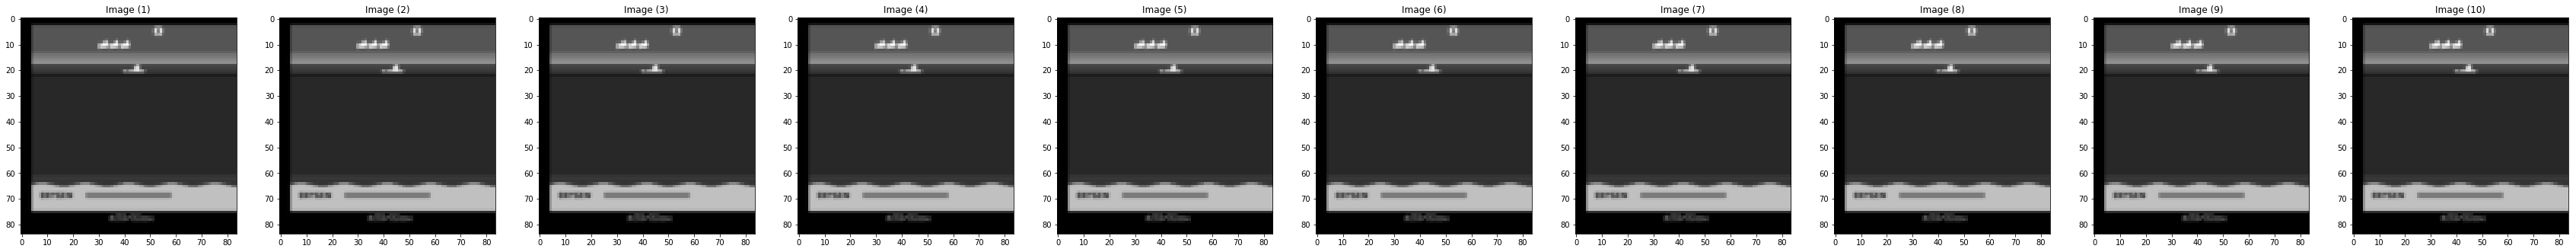

In [140]:
#prebatch_s,batch_a,batch_r,prebatch_s_,batch_done = t_agent.longmem.sample(32)# a batch of episode of parameter length
idx = 30
show_images(np.expand_dims(chase.memory.screens[3300:3310],-1))
#show_images(prebatch_s_[idx])

In [53]:
import moviepy.editor as mpy

In [108]:

def gif(filename, array, fps=10, scale=1.0):
    """Creates a gif given a stack of images using moviepy
    Notes
    -----
    works with current Github version of moviepy (not the pip version)
    https://github.com/Zulko/moviepy/commit/d4c9c37bc88261d8ed8b5d9b7c317d13b2cdf62e
    Usage
    -----
    >>> X = randn(100, 64, 64)
    >>> gif('test.gif', X)
    Parameters
    ----------
    filename : string
        The filename of the gif to write to
    array : array_like
        A numpy array that contains a sequence of images
    fps : int
        frames per second (default: 10)
    scale : float
        how much to rescale each image by (default: 1.0)
    """

    # ensure that the file has the .gif extension
    #fname, _ = os.path.splitext(filename)
    #filename = fname + '.gif'

    # copy into the color dimension if the images are black and white
    #if array.ndim == 3:
    #    array = array[..., np.newaxis] * np.ones(3)

    # make the moviepy clip
    clip = mpy.ImageSequenceClip(list(array), fps=fps)
    return clip

In [129]:
c_clip = gif(None,chase.memory.screens)
r_clip = gif(None,np.squeeze(r3.longmem.mem_s,-1))

In [131]:
c_clip.write_gif("test.gif",verbose=False)






  0%|          | 0/5001 [00:00<?, ?it/s]




  1%|          | 37/5001 [00:00<00:13, 365.70it/s]




  1%|▏         | 74/5001 [00:00<00:13, 366.38it/s]




  2%|▏         | 107/5001 [00:00<00:13, 352.25it/s]




  3%|▎         | 140/5001 [00:00<00:14, 342.91it/s]




  3%|▎         | 174/5001 [00:00<00:14, 338.93it/s]




  4%|▍         | 213/5001 [00:00<00:13, 351.65it/s]




  5%|▍         | 249/5001 [00:00<00:13, 353.95it/s]




  6%|▌         | 287/5001 [00:00<00:13, 360.45it/s]




  6%|▋         | 325/5001 [00:00<00:12, 364.94it/s]




  7%|▋         | 361/5001 [00:01<00:12, 358.90it/s]




  8%|▊         | 396/5001 [00:01<00:13, 352.36it/s]




  9%|▊         | 432/5001 [00:01<00:12, 353.62it/s]




  9%|▉         | 470/5001 [00:01<00:12, 360.03it/s]




 10%|█         | 506/5001 [00:01<00:12, 359.97it/s]




 11%|█         | 542/5001 [00:01<00:12, 359.25it/s]




 12%|█▏        | 578/5001 [00:01<00:12, 345.95it/s]




 12%|█▏        | 613/5001 [00:01<00:12, 344.00it/s]






 83%|████████▎ | 4170/5001 [00:12<00:02, 340.84it/s]



 84%|████████▍ | 4205/5001 [00:12<00:02, 331.55it/s]



 85%|████████▍ | 4239/5001 [00:12<00:02, 333.31it/s]



 85%|████████▌ | 4273/5001 [00:12<00:02, 331.59it/s]



 86%|████████▌ | 4307/5001 [00:12<00:02, 333.77it/s]



 87%|████████▋ | 4341/5001 [00:12<00:01, 331.71it/s]



 88%|████████▊ | 4376/5001 [00:12<00:01, 334.95it/s]



 88%|████████▊ | 4411/5001 [00:12<00:01, 338.02it/s]



 89%|████████▉ | 4446/5001 [00:12<00:01, 341.22it/s]



 90%|████████▉ | 4481/5001 [00:13<00:01, 337.53it/s]



 90%|█████████ | 4516/5001 [00:13<00:01, 337.99it/s]



 91%|█████████ | 4550/5001 [00:13<00:01, 336.24it/s]



 92%|█████████▏| 4584/5001 [00:13<00:01, 330.81it/s]



 92%|█████████▏| 4618/5001 [00:13<00:01, 333.10it/s]



 93%|█████████▎| 4652/5001 [00:13<00:01, 332.52it/s]



 94%|█████████▎| 4686/5001 [00:13<00:00, 327.59it/s]



 94%|█████████▍| 4720/5001 [00:13<00:00, 329.58it/s]



 95%|█████████▌| 4753/5001 [00:13<00:00, 327.05i

In [95]:
testclip = mpy.VideoFileClip("test.gif")
testclip.preview()

time, position, color :  6.333, (38, 57), [31 31 31]
time, position, color :  6.400, (38, 57), [31 31 31]
time, position, color :  6.400, (38, 57), [31 31 31]


KeyboardInterrupt: 

In [ ]:
pre_s = atari_env.reset()
mem_s = t_agent.preprocessor.process_state_for_memory(pre_s) #scaled and grayscaled
net_s = t_agent.preprocessor.process_for_network(mem_s) # normalized
done = False
t_agent.shortmem.forget() # forget short term memory for recurrent network 
t_agent.shortmem.add(net_s)
atari_env.render()

In [ ]:
hist_s = t_agent.shortmem.get()
a = t_agent.act(hist_s)
atari_env.render()

pre_s_, r, done, info = atari_env.step(a)

mem_s_ = t_agent.preprocessor.process_state_for_memory(pre_s) #scaled and grayscaled
net_s_ = t_agent.preprocessor.process_for_network(mem_s) # normalized
t_agent.shortmem.add(net_s_)
t_agent.remember(mem_s,a,r,done)

In [ ]:
t_agent.act(hist_s)

In [ ]:
show_images(net_s[None]*255.0)

In [ ]:
hist_s = t_agent.shortmem.get()

In [ ]:
show_images(hist_s*255.0)

In [ ]:
t_agent.shortmem.mem_hist.shape

In [ ]:
t_agent.shortmem.current

In [ ]:
import argparse

In [ ]:
parser = argparse.ArgumentParser(description='Run DQN on Atari Breakout')
parser.add_argument('--env', default='Seaquest-v0', help='Atari env name')
parser.add_argument('-o', '--output', default='./log/', help='Directory to save data to')
parser.add_argument('--seed', default=0, type=int, help='Random seed')
parser.add_argument('--gamma', default=0.99, type=float, help='Discount factor')
parser.add_argument('--batch_size', default=32, type=int, help='Minibatch size')
parser.add_argument('--learning_rate', default=0.0001, type=float, help='Learning rate')
parser.add_argument('--initial_epsilon', default=1.0, type=float, help='Initial exploration probability in epsilon-greedy')
parser.add_argument('--final_epsilon', default=0.05, type=float, help='Final exploration probability in epsilon-greedy')
parser.add_argument('--exploration_steps', default=1000000, type=int, help='Number of steps over which the initial value of epsilon is linearly annealed to its final value')
parser.add_argument('--num_samples', default=100000000, type=int, help='Number of training samples from the environment in training')
parser.add_argument('--num_frames', default=4, type=int, help='Number of frames to feed to Q-Network')
parser.add_argument('--frame_width', default=84, type=int, help='Resized frame width')
parser.add_argument('--frame_height', default=84, type=int, help='Resized frame height')
parser.add_argument('--replay_memory_size', default=1000000, type=int, help='Number of replay memory the agent uses for training')
parser.add_argument('--target_update_freq', default=10000, type=int, help='The frequency with which the target network is updated')
parser.add_argument('--train_freq', default=4, type=int, help='The frequency of actions wrt Q-network update')
parser.add_argument('--save_freq', default=50000, type=int, help='The frequency with which the network is saved')
parser.add_argument('--eval_freq', default=50000, type=int, help='The frequency with which the policy is evlauted')    
parser.add_argument('--num_burn_in', default=50000, type=int, help='Number of steps to populate the replay memory before training starts')
parser.add_argument('--load_network', default=False, action='store_true', help='Load trained mode')
parser.add_argument('--load_network_path', default='', help='the path to the trained mode file')
parser.add_argument('--net_mode', default='dqn', help='choose the mode of net, can be linear, dqn, duel')
parser.add_argument('--max_episode_length', default = 10000, type=int, help = 'max length of each episode')
parser.add_argument('--num_episodes_at_test', default = 20, type=int, help='Number of episodes the agent plays at test')
parser.add_argument('--ddqn', default=False, dest='ddqn', action='store_true', help='enable ddqn')
parser.add_argument('--train', default=True, dest='train', action='store_true', help='Train mode')
parser.add_argument('--test', dest='train', action='store_false', help='Test mode')
parser.add_argument('--no_experience', default=False, action='store_true', help='do not use experience replay')
parser.add_argument('--no_target', default=False, action='store_true', help='do not use target fixing')
parser.add_argument('--no_monitor', default=False, action='store_true', help='do not record video')
parser.add_argument('--task_name', default='', help='task name')
parser.add_argument('--recurrent', default=False, dest='recurrent', action='store_true', help='enable recurrent DQN')
parser.add_argument('--a_t', default=False, dest='a_t', action='store_true', help='enable temporal/spatial attention')
parser.add_argument('--global_a_t', default=False, dest='global_a_t', action='store_true', help='enable global temporal attention')
parser.add_argument('--selector', default=False, dest='selector', action='store_true', help='enable selector for spatial attention')
parser.add_argument('--bidir', default=False, dest='bidir', action='store_true', help='enable two layer bidirectional lstm')

In [ ]:
args = parser.parse_args("--gamma 0.9")